In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load config
import json
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import sys
sys.path.append('../../../utils')
sys.path.append('../../..')

In [3]:
IMAGE_SHAPE = (1000, 1000)
CONFIG_PATH = '../../../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

### Создадим агрегатор

In [4]:
from src.aggregate.base import Aggregator, ComposeClassifier
from src.aggregate.threshold import ThresholdClassifier
from src.aggregate.noborder import NoBorderClassifier
from src.aggregate.confidence import ConfidenceClassifier
from src.aggregate.merge import UnionMerger

In [5]:
N_CLASSES = 2
INTEGRATE_THRESHOLD = 1
CONFIDENCE_THRESHOLD = 0.83

In [6]:
noborder_classifier = NoBorderClassifier(N_CLASSES, IMAGE_SHAPE)
threshold_classifier = ThresholdClassifier(N_CLASSES, 1)
confidence_classifier = ConfidenceClassifier(N_CLASSES, CONFIDENCE_THRESHOLD)
classifier = ComposeClassifier([
    noborder_classifier,
    threshold_classifier,
    confidence_classifier,
])
merger = UnionMerger(N_CLASSES)
aggregator = Aggregator(classifier, merger)

### Интерполированный тест

In [7]:
import pickle
import json
TEST_NAME = 'sparse'
with open(f'../../../groups/gt_test_{TEST_NAME}.pkl', 'rb') as f:
    gt_extended_groups = pickle.load(f)
with open(f'../../../groups/pred_test_{TEST_NAME}.pkl', 'rb') as f:
    pred_extended_groups = pickle.load(f)
with open(f'../../../data/{TEST_NAME}_test/speed.json') as f:
    speed_dict = json.load(f)
    shifts = {}
    speed_sum = 0
    for k, v in sorted(speed_dict.items(), key=lambda x: x[0]):
        speed_sum += v
        shifts[Path(k).name] = speed_sum

Median group size: 21


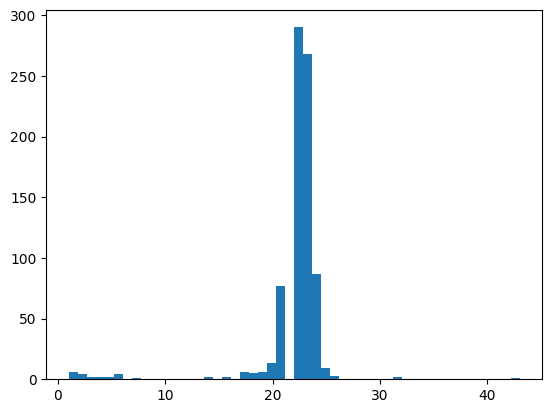

In [8]:
plt.hist([len(g) for g in gt_extended_groups], bins=50)
median_length = int(np.median([len(g) for g in pred_extended_groups]))
print(f"Median group size: {median_length}")

### Получим группы на ленте

In [9]:
from copy import deepcopy
import random
from utils.integrate.integrate import shift_mask
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box

def align_group(ext_group, shifts):
    ext_group = deepcopy(ext_group)
    for obj in ext_group:
        shift = shifts[obj['img'].name]
        conf = None
        if 'conf' in obj['obj']:
            conf = float(obj['obj']['conf'])
        obj['obj'] = shift_mask(obj['obj'], shift)
        obj['obj']['is_border'] = obj['is_border']
        if conf is not None:
            obj['obj']['conf'] = conf
    return ext_group

def align_groups(ext_group, shifts):
    return [
        align_group(ext_group, shifts)
        for ext_group in ext_group
    ]

In [10]:
gt_aligned_groups = align_groups(gt_extended_groups, shifts)
pred_aligned_groups = align_groups(pred_extended_groups, shifts)

In [11]:
gt_groups = [[o['obj'] for o in g] for g in gt_aligned_groups]
pred_groups = [[o['obj'] for o in g]  for g in pred_aligned_groups]

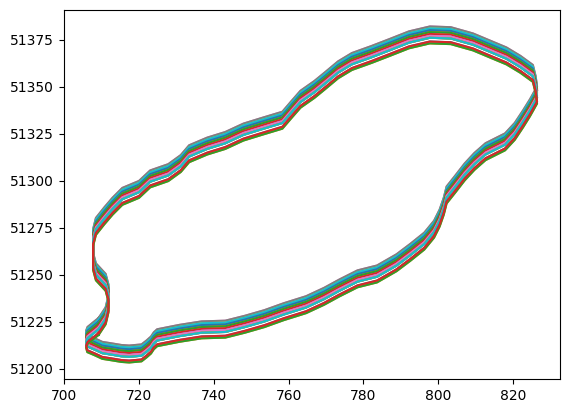

In [12]:
for polygon in map(poly, gt_groups[random.randint(0, len(gt_groups))]):
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()

### Агрегация

In [13]:
len(pred_groups)

879

In [14]:
pred_groups[0][0]

{'cls': '0',
 'points': array([[     541.45,      563.89],
        [     541.45,      566.82],
        [      539.5,      568.77],
        [      539.5,      569.74],
        [     537.55,      571.69],
        [     537.55,      572.67],
        [     536.57,      573.64],
        [     536.57,      574.62],
        [      535.6,       575.6],
        [      535.6,      576.57],
        [     534.62,      577.55],
        [     534.62,      578.52],
        [     533.65,       579.5],
        [     533.65,      581.45],
        [     532.67,      582.42],
        [     532.67,       583.4],
        [     531.69,      584.38],
        [     531.69,      585.35],
        [     530.72,      586.33],
        [     530.72,       587.3],
        [     528.77,      589.25],
        [     528.77,      590.23],
        [     527.79,      591.21],
        [     527.79,      592.18],
        [     526.82,      593.16],
        [     526.82,      595.11],
        [     525.84,      596.08],
     

In [15]:
gt = aggregator.aggregate(gt_groups)
pred = aggregator.aggregate(pred_groups)

In [16]:
len(pred)

590

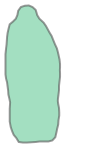

In [17]:
poly(gt[random.randint(0, len(gt))])

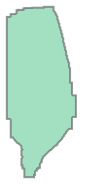

In [18]:
poly(pred[random.randint(0, len(pred))])

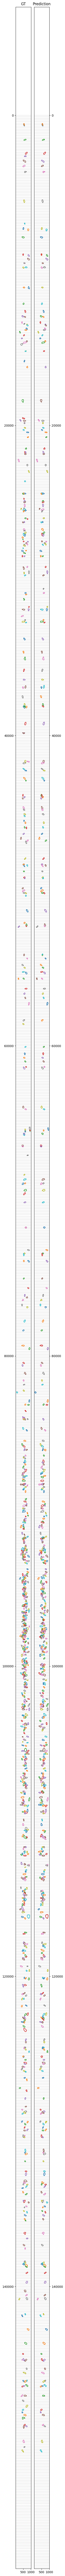

In [19]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, max(shifts.values()) / 1000))

for polygon in map(poly, gt):
    x, y = polygon.exterior.xy
    ax1.plot(x, y)
ax1.invert_yaxis()
ax1.set_title('GT')

for polygon in map(poly, pred):
    x, y = polygon.exterior.xy
    ax2.plot(x, y)
ax2.invert_yaxis()
ax2.set_title('Prediction')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

xlim = (min(ax.get_xlim()[0] for ax in [ax1, ax2]), max(ax.get_xlim()[1] for ax in [ax1, ax2]))
ylim = (min(ax.get_ylim()[0] for ax in [ax1, ax2]), max(ax.get_ylim()[1] for ax in [ax1, ax2]))

for ax in [ax1, ax2]:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


min_ylim = 0
max_ylim = min(ax.get_ylim()[0] for ax in [ax1, ax2])
for ax in [ax1, ax2]:
    step = 100  # Draw line every 100 pixels
    for y in range(int(min_ylim), int(max_ylim), step):
        ax.axhline(y=y, color='gray', alpha=0.2, linestyle='-')

plt.show()

### Метрики

In [20]:
from tqdm import tqdm 

def boxes_intersect(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Check if one box is to the right of the other
    if x1 + w1 <= x2 or x2 + w2 <= x1:
        return False
        
    # Check if one box is above the other
    if y1 + h1 <= y2 or y2 + h2 <= y1:
        return False
        
    return True

def find_matches(gt : list[dict], pred : list[dict], iou_threshold : float = 0.7):
    gt_boxes = [get_box(t) for t in gt]
    pred_boxes = [get_box(t) for t in pred]

    gt_matches = [False] * len(gt)
    pred_matches = [False] * len(pred)

    for i, gt_obj in tqdm(enumerate(gt), total=len(gt)):
        for j, pred_obj in enumerate(pred):
            if boxes_intersect(gt_boxes[i], pred_boxes[j]):
                iou = mask_iou(gt_obj, pred_obj)
                if iou > iou_threshold:
                    gt_matches[i] = True
                    pred_matches[j] = True
    return np.array(gt_matches), np.array(pred_matches)

In [21]:
gt_matches, pred_matches = find_matches(gt, pred)

  4%|▍         | 30/789 [00:00<00:02, 298.01it/s]

100%|██████████| 789/789 [00:28<00:00, 27.27it/s] 


In [22]:
precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.9610
Recall: 0.7262
F1 Score: 0.8273


### Визуализация группы

In [23]:
iidx = 0
gidx = 20

False True runs/segment/predict/tula_sep_0002_2024_07_22_18_00_36_200.jpg
8796


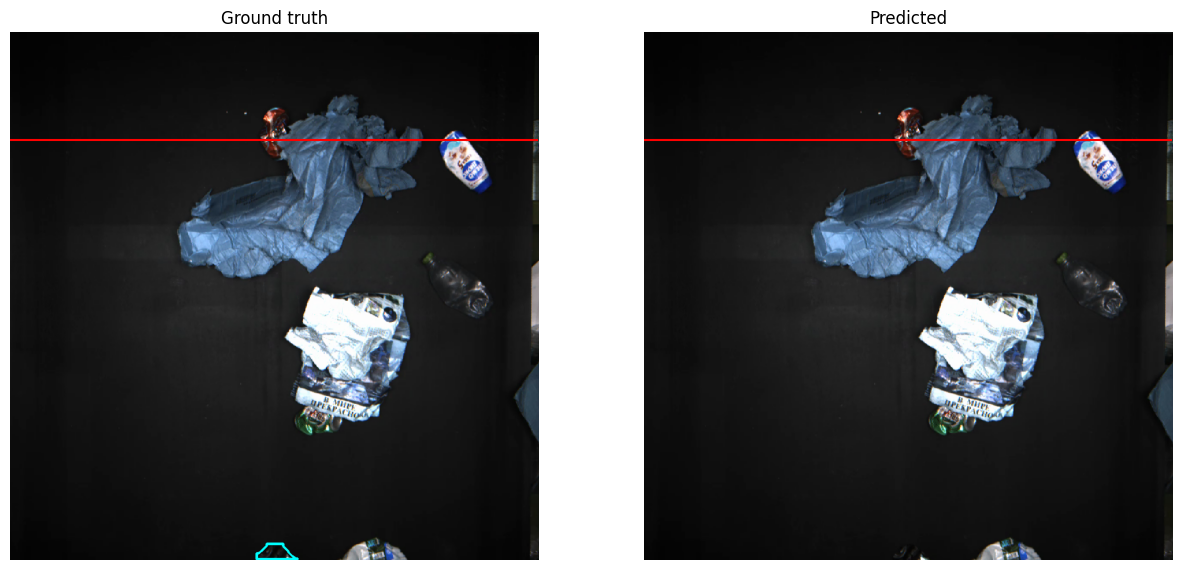

In [24]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from utils.interpolate.markup_utils import vis_markup

for instance in pred_extended_groups[gidx][iidx:iidx+1]:
    print(instance['is_matched'], instance['is_border'], instance['img'])
    name = Path(instance['img']).name
    s = shifts[name] % 1000
    img = cv2.imread(Path('/alpha/projects/wastie/code/kondrashov/delta/data/sparse_test/imgs') / name)
    img = vis_markup(img, [instance['obj']])
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].set_title('Ground truth')
    axs[0].axis('off')
    axs[0].imshow(img)
    axs[0].axhline(y=img.shape[0]-s, color='r', linestyle='-')
    img_gt = cv2.imread(Path('/alpha/projects/wastie/code/kondrashov/delta/data/sparse_test/imgs') / name)
    img_gt = vis_markup(img_gt, [shift_mask(obj, -s) for obj in pred_groups[gidx]])
    axs[1].set_title('Predicted')
    axs[1].axis('off')
    axs[1].imshow(img_gt)
    axs[1].axhline(y=img_gt.shape[0]-s, color='r', linestyle='-')
    
    
iidx += 1
print(shifts[name])

plt.show()

In [25]:
iidx = 0
gidx += 1